In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import load_model
from keras import layers
import os
import tensorflow as tf
import datetime
from collections import deque
from keras.callbacks import ModelCheckpoint


In [117]:

df_all = pd.read_csv('NVDA.csv')
df_all.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
df_all['Date'] = pd.to_datetime(df_all['Date'])
df_all = df_all[['Date', 'Close']]

train_df = pd.read_csv('NVDA_train.csv')
train_df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df = train_df[['Date', 'Close']]
train_df.index = train_df.pop('Date')

test_df = pd.read_csv('NVDA_test.csv')
test_df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df = test_df[['Date', 'Close']]
test_df.index = test_df.pop('Date')


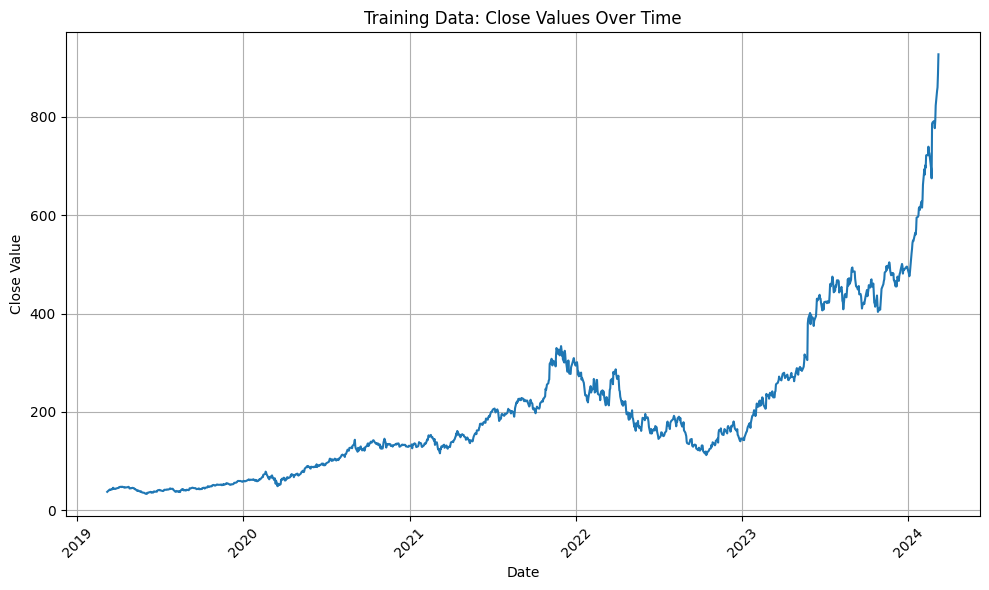

In [100]:
plt.figure(figsize=(10, 6))
plt.plot(df_all['Date'], df_all['Close'], marker='', linestyle='-')
plt.title('Training Data: Close Values Over Time')
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# datapreprocessing for lstm

In [101]:

def generate_windowed_dataset(dataframe, start_date_str, end_date_str, column_name, window_size=3):
    start_date = pd.to_datetime(start_date_str)
    end_date = pd.to_datetime(end_date_str)

    target_date = start_date
    dates = []
    X, y = [], []

    while True:
        window_data = dataframe.loc[:target_date].tail(window_size + 1)

        if len(window_data) != window_size + 1:
            print(f'Error: Window of size {window_size} is too large for date {target_date}')
            return

        values = window_data[column_name].to_numpy()
        X.append(values[:-1])
        y.append(values[-1])
        dates.append(target_date)

        next_date = target_date + pd.DateOffset(days=1)

        if next_date > end_date:
            break

        target_date = next_date

    ret_df = pd.DataFrame({'Target Date': dates})
    for i in range(window_size):
        ret_df[f'Target-{window_size-i}'] = np.array(X)[:, i]
    ret_df['Target'] = y

    return ret_df


# windowed_df = generate_windowed_dataset(train_df, '2021-08-25', '2022-03-23', 'Close', 3)

# windowed_df


In [102]:
def prepare_dataset_for_lstm(windowed_dataframe):
    dates = windowed_dataframe['Target Date'].to_numpy()
    X = windowed_dataframe.iloc[:, 1:-1].to_numpy().reshape(len(windowed_dataframe), -1, 1)
    y = windowed_dataframe['Target'].to_numpy()
    return dates, X.astype(np.float32), y.astype(np.float32)

# LSTM Baseline

## preprocessing

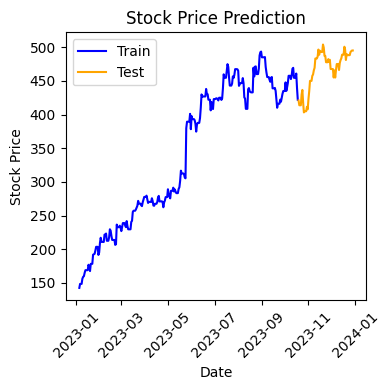

In [103]:
windowed_df = generate_windowed_dataset(train_df, '2023-01-05', '2023-12-29', 'Close', 3)
dates, X, y = prepare_dataset_for_lstm(windowed_df)

split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]
dates_train, dates_val = dates[:split], dates[split:]

# plot
plt.figure(figsize=(4, 4))
plt.plot(dates_train, y_train, label='Train', color='blue')
plt.plot(dates_val, y_val, label='Test', color='orange')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## training

In [113]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)


save_dir = 'trained_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

model.save(os.path.join(save_dir, 'baseline_2.keras'))

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 129725.0547 - mean_absolute_error: 345.3162 - val_loss: 223562.4219 - val_mean_absolute_error: 465.8781
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 126476.2578 - mean_absolute_error: 340.3822 - val_loss: 222747.5000 - val_mean_absolute_error: 465.0131
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 124989.8516 - mean_absolute_error: 338.0028 - val_loss: 221600.7969 - val_mean_absolute_error: 463.7961
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 124058.3906 - mean_absolute_error: 336.5078 - val_loss: 220359.8594 - val_mean_absolute_error: 462.4731
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 122036.3672 - mean_absolute_error: 333.4908 - val_loss: 218764.2031 - val_mean_absolute_error: 460.7680
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 116991.5938 - mean_absolute_error: 326.4797 - val_loss: 216832.0469 - val_mean_absolute_error: 458.6938
Epoch 7/100
9/9 ━━━━━━━━━━━━━

## plotting

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


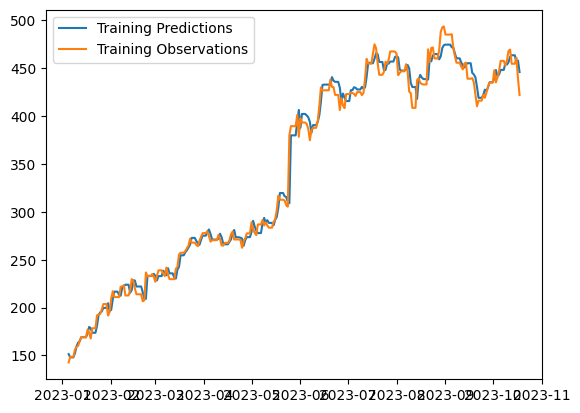

In [114]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


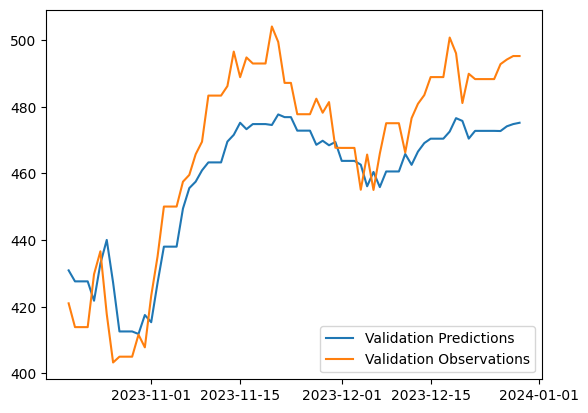

In [115]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

## evaluating on test set

In [136]:
%pip install --upgrade tensorflow keras



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [138]:
from keras.models import load_model
from keras.optimizers import Adam


model = load_model('trained_models/baseline_2.keras')


windowed_test_df = generate_windowed_dataset(test_df, '2024-01-05', '2024-01-15', 'Close',3)
dates_test, X_test, y_test = prepare_dataset_for_lstm(windowed_test_df)

# print(dates_test)

loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Mean Absolute Error: {mae}')

n = 3
s = 1


values = test_df[['Close']].iloc[s:s+3].to_numpy().flatten().tolist()
dates = test_df.iloc[s:s+n].index.to_list()

print(dates)


measures = deque(values, maxlen=3)
measures_list = list(measures)

print(measures)
print(measures_list)

for date in range(n-3):
    x = np.array(measures, dtype=float).reshape((1,3,1))
    pred_measure = model.predict(x).flatten()[0]
    measures.append(pred_measure)
    values.append(pred_measure)


plt.figure(figsize=(10, 4))
# plt.plot(df)
plt.plot(dates, values, label='Test Predictions')
plt.plot(dates, test_df[['Close']].iloc[s:s+n].to_numpy().flatten().tolist(), label='Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Test Predictions vs Actual Stock Prices')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

ValueError: A total of 1 objects could not be loaded. Example error message for object <keras.src.optimizers.adam.Adam object at 0x000001DEC89769F0>:

Unable to get group info (bad symbol table node signature)

List of objects that could not be loaded:
[<keras.src.optimizers.adam.Adam object at 0x000001DEC89769F0>]

# Returns 

In [ ]:
train_df = pd.read_csv('NVDA_train.csv')
train_df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df = train_df[['Date', 'Close']]
train_df.index = train_df.pop('Date')

df_returns = train_df
df_returns['Return'] = df_returns['Close'].pct_change() * 100
df_returns.drop(columns=['Close'], inplace=True)
df_returns.dropna(inplace=True)
print(df_returns)

              Return
Date                
2019-03-11  6.970260
2019-03-12  0.856401
2019-03-13  3.753379
2019-03-14 -1.814731
2019-03-15  2.567045
...              ...
2023-12-22 -0.326598
2023-12-26  0.919521
2023-12-27  0.280039
2023-12-28  0.212475
2023-12-29  0.000000

[1212 rows x 1 columns]


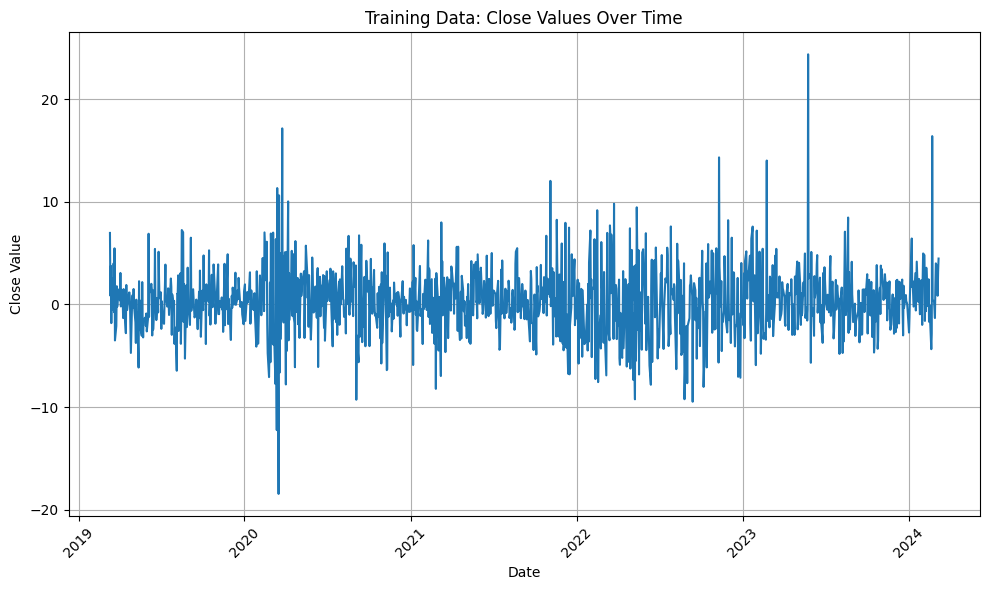

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_returns['Date'], df_returns['Return'], marker='', linestyle='-')
plt.title('Training Data: Close Values Over Time')
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


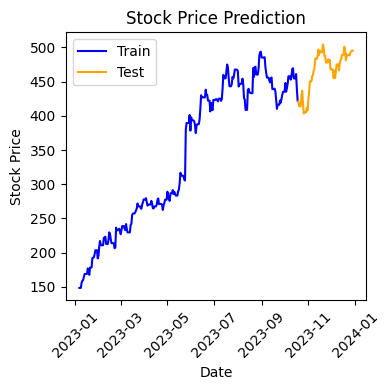

In [ ]:
windowed_df = generate_windowed_dataset(df_returns, '2023-01-06', '2023-12-29', 'Return', 3)
dates, X, y = prepare_dataset_for_lstm(windowed_df)

split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]
dates_train, dates_val = dates[:split], dates[split:]

# plot
plt.figure(figsize=(4, 4))
plt.plot(dates_train, y_train, label='Train', color='blue')
plt.plot(dates_val, y_val, label='Test', color='orange')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Training

In [ ]:
model = Sequential([
    layers.Input((3, 1)),
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

# Define a ModelCheckpoint callback
checkpoint_path = os.path.join(save_dir, 'return.keras')
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_loss',  # Choose the metric to monitor
                             save_best_only=True,  # Save only the best model
                             mode='min',  # 'min' for validation loss, 'max' for accuracy, 'auto' for automatic
                             verbose=1)

# Train the model with the callback
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=1000, 
                    callbacks=[checkpoint])


Epoch 1/1000
1/9 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - loss: 102646.6875 - mean_absolute_error: 304.8998
Epoch 1: val_loss improved from inf to 223543.67188, saving model to trained_models\return.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 122532.9219 - mean_absolute_error: 334.7337 - val_loss: 223543.6719 - val_mean_absolute_error: 465.8576
Epoch 2/1000
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 127236.9062 - mean_absolute_error: 342.5621 
Epoch 2: val_loss improved from 223543.67188 to 222449.20312, saving model to trained_models\return.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 127185.4609 - mean_absolute_error: 342.2504 - val_loss: 222449.2031 - val_mean_absolute_error: 464.6957
Epoch 3/1000
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 129272.0312 - mean_absolute_error: 345.4904
Epoch 3: val_loss improved from 222449.20312 to 221009.32812, saving model to trained_models\return.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 128848.4141 - mean_absolute_error: 34

In [ ]:
# Load the best model 
return_model = load_model('trained_models/baseline.keras')
train_predictions = return_model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

ValueError: File not found: filepath=trained_modelseturn.keras. Please ensure the file is an accessible `.keras` zip file.

# Comments

In [ ]:
# Very bad extrapolation (learn data outside its range), for it to better extrapolate we can train it on a smaller interval closer the dates we actually want to predict
# In most models its good to minmax scale, but not in the case of stock market predictions because there is no maximum value prices are always increasing 
